This was the initial code for the project analyzing Drug Mortality in Connecticut. In this I use
1. BeautifulSoup to webscrape Wikipedia to get county names in Connectticut.
2. Use API from CT government to get drug mortality data.
3. Use google geocode to get the latitude and longitude information for each county. Turns out that there are only 8 counties in CT, so getting the locations of those 8 at once gives much better performance over getting location every time for each row.
4. Use gmaps to plot a heatmap. This shows locations of highest deaths.

Why this code was discarded.
1. The API does not give the latest and greatest data. There is a speadsheet on data.gov which has latest data.
2. Heatmap is not very nice to visualize the data here - there are only 8 spots on the map, and it does not look good. Choropleth is a better map to use. 
3. Because of #2, I do not need latitude, longitude location.

Neverthless, this taught me a thing or two :-).

In [1]:
import pandas as pd
import gmplot
import requests
from bs4 import BeautifulSoup
from config import gkey
import gmaps
import re
from pprint import pprint
from sodapy import Socrata
import numpy as np
from IPython.display import Image
%matplotlib inline

In [2]:
wiki = "https://en.wikipedia.org/wiki/List_of_counties_in_Connecticut"
req = requests.get(wiki)
soup = BeautifulSoup(req.text,"lxml")
table = soup.find("table", { "class" : "wikitable sortable" })

In [3]:
counties_list = []
for row in table.findAll("tr"):
    cells = row.findAll("td")
    if cells:
        county = cells[0].find(text=True)
        county = re.sub("County","",county).title().rstrip()
        counties_list.append(county)
counties_list

['Fairfield',
 'Hartford',
 'Litchfield',
 'Middlesex',
 'New Haven',
 'New London',
 'Tolland',
 'Windham']

In [4]:
geo_location = {county:{} for county in counties_list}
for county in counties_list:
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?" \
            f"address={county} county,CT&key={gkey}"
    try:
        geo_data = requests.get(target_url).json() 
        lat = geo_data["results"][0]["geometry"]["location"]["lat"]
        lng = geo_data["results"][0]["geometry"]["location"]["lng"]
    except Exception as exp:
        print(f"ERROR2:{exp}, {geo_data}")
        lat = ""
        lng = ""
    geo_location[county]["lat"] = lat
    geo_location[county]['lng'] = lng
    
pprint(geo_location)

{'Fairfield': {'lat': 41.2559654, 'lng': -73.37086959999999},
 'Hartford': {'lat': 41.7924343, 'lng': -72.8042797},
 'Litchfield': {'lat': 41.7866294, 'lng': -73.2765361},
 'Middlesex': {'lat': 41.46985050000001, 'lng': -72.4731529},
 'New Haven': {'lat': 41.3266911, 'lng': -72.8042797},
 'New London': {'lat': 41.5185189, 'lng': -72.0468164},
 'Tolland': {'lat': 41.8418987, 'lng': -72.37846789999999},
 'Windham': {'lat': 41.8275622, 'lng': -72.0468164}}


In [5]:
client = Socrata("data.ct.gov", None)
results = client.get("u2qy-687x")
results_df = pd.DataFrame.from_records(results)
results_df.columns

Index([':@computed_region_dam5_q64j', ':@computed_region_m4y2_whse',
       ':@computed_region_nhmp_cq6b', ':@computed_region_snd5_k6zv', 'age',
       'amphet', 'any_opioid', 'benzo_s', 'casenumber', 'coc', 'date',
       'death_city', 'death_county', 'death_state', 'deathloc',
       'deathloc_city', 'deathloc_state', 'etoh', 'fentanyl', 'heroin',
       'hydr_cod', 'immediatecausea', 'injuryplace', 'location',
       'mannerofdeath', 'methadone', 'morphine_not_heroin', 'other', 'oxyc',
       'oxym', 'race', 'residence_city', 'residence_county', 'residence_state',
       'sex', 'tramad'],
      dtype='object')

In [6]:
results_df = results_df.dropna(subset=['death_county'])
target_url = f"https://maps.googleapis.com/maps/api/geocode/json?" \
            f"address=Hartford,CT,USA&key={gkey}"
try:
    geo_data = requests.get(target_url).json() 
    CT_lat = geo_data["results"][0]["geometry"]["location"]["lat"]
    CT_lng = geo_data["results"][0]["geometry"]["location"]["lng"]
except:
    print ("Cannot find geocode for Hartford")

In [7]:
gmap = gmplot.GoogleMapPlotter(CT_lat,CT_lng,10)

In [8]:
def get_geocode(row):
    place = row["death_county"].title()
    try:
        row["lat"] = geo_location[place]["lat"]
        row['lng'] = geo_location[place]["lng"]
    except:
        print (f"Cannot find {place} in CT counties, {row.name}.")
        row["lat"] = np.nan
        row["lng"] = np.nan
    return row

In [9]:
results_df = results_df.apply(get_geocode,axis=1)
#results_df["lng"] = results_df.apply(get_geolng, axis=1)
results_df = results_df.dropna(subset=['lat','lng'])
results_df.head()

Cannot find Usa in CT counties, 243.


:@computed_region_dam5_q64j :@computed_region_m4y2_whse  \
0                        1045                          59   
1                        1044                         151   
3                        1044                         148   
4                        1044                         156   
5                        1040                          34   

  :@computed_region_nhmp_cq6b :@computed_region_snd5_k6zv age amphet  \
0                         243                           8  53    NaN   
1                         167                           4  30    NaN   
3                         195                           7  24    NaN   
4                          11                           7  26    NaN   
5                           1                           9  45    NaN   

  any_opioid benzo_s casenumber  coc    ...     oxyc oxym   race  \
0        NaN       Y   13-16336  NaN    ...        Y    Y  White   
1        NaN     NaN   12-18447    Y    ...        Y  NaN  White   
3        NaN     NaN   14-13497  NaN    ...      NaN  NaN  White   
4        NaN     NaN   13-14421  NaN    ...      NaN  NaN  White   
5        NaN       Y   13-18018  NaN    ...      NaN  NaN  White   

  residence_city residence_county residence_state     sex tramad        lat  \
0         GROTON       NEW LONDON             NaN  Female    NaN  41.518519   
1        WOLCOTT        NEW HAVEN             NaN    Male    NaN  41.326691   
3    WALLINGFORD              NaN             NaN  Female    NaN  41.326691   
4     WEST HAVEN        NEW HAVEN             NaN  Female    NaN  41.326691   
5     RIDGEFIELD        FAIRFIELD             NaN  Female    NaN  41.255965   

         lng  
0 -72.046816  
1 -72.804280  
3 -72.804280  
4 -72.804280  
5 -73.370870  

[5 rows x 38 columns]

In [10]:
gmap.heatmap(results_df.lat, results_df.lng)
gmap.draw("my_heatmap.html")

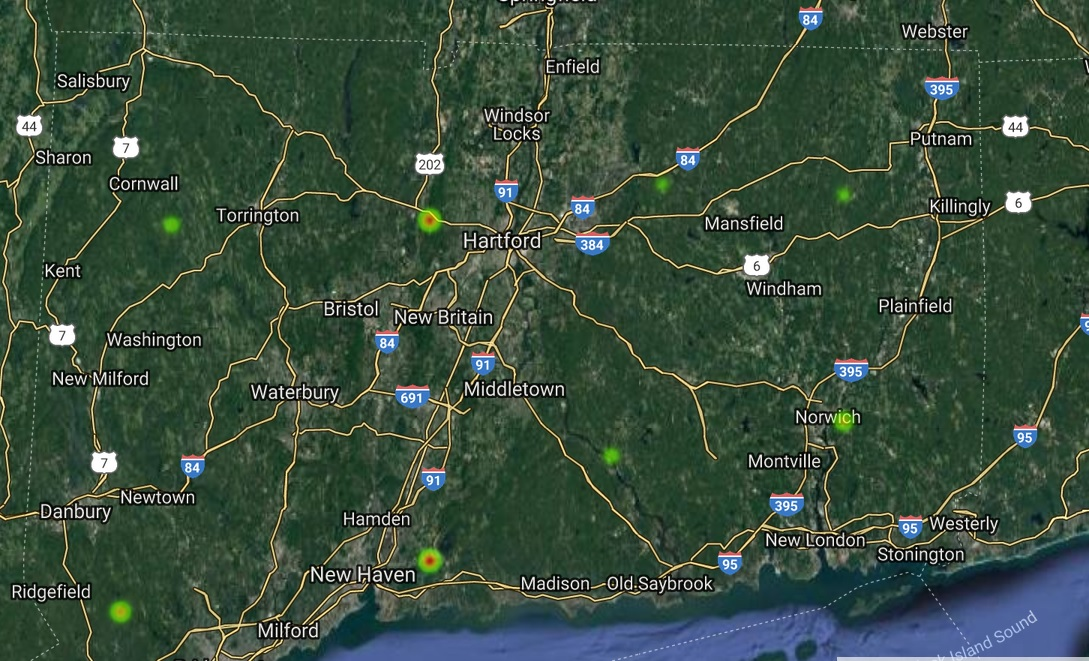

In [11]:
Image("./county_heatmap_google.jpg")